# load data from Hansen (21st century forest cover), Dinerstein (biome)
# plot biome and forested/deforested locations on a map

### define data paths
#### all data available on Zenodo at: 10.5281/zenodo.5707740

In [1]:

data_path_biome     =    '/Users/lukeaparsons/Documents/Data/Observations/biome/' #spatially gridded at 1kmx1km, modified from Dinerstein et al. tropical and subtropical forest biome
data_path_cover     =    '/Users/lukeaparsons/Documents/Data/Observations/Hansen/' #spatially gridded at 1kmx1km, modified from Hansen et al. forest cover


## Import modules


In [2]:

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import special #note this is used in Kjellstrom 2018 erf
import time as tm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib as mpl

In [3]:
## define thresholds etc used in analysis

CoverThreshold = 75 #set forest cover threshold to 75% for forested areas

LossYearCutoff = 2003 #all loss must happen in or after this year bc this is when MODIS obs start

regions = ['Americas','Africa','Asia']

## load biome data


In [4]:
for ri,region in enumerate(regions):
    vars()[str(region)+'_bio'] = xr.open_dataset(data_path_biome + str(region) + '_biome_mask.nc')
    if region == 'Americas':
        vars()[str(region)+'_biome'] = vars()[str(region)+'_bio']['americas_biome_mask']
    if region == 'Africa':
        vars()[str(region)+'_biome'] = vars()[str(region)+'_bio']['Feature_shp1']
    if region == 'Asia':
        vars()[str(region)+'_biome'] = vars()[str(region)+'_bio']['Feature_shp3']
        
    #remove non-number locations, keep 1 where biome
    vars()[str(region)+'_biome'].where(vars()[str(region)+'_biome'] == 1)
    
    print(region, 'first lat is: ',vars()[str(region)+'_biome'].lat[0].values, 'and first lon is: ',vars()[str(region)+'_biome'].lon[0].values)
    print('shape of ', region,' is ', vars()[str(region)+'_biome'].shape)

Americas first lat is:  29.99583333065268 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
Africa first lat is:  29.9958333306271 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
Asia first lat is:  29.99583333065268 and first lon is:  60.004166661278134
shape of  Asia  is  (7200, 14400)


## load forest cover, loss data


In [5]:

for ri,region in enumerate(regions):
    
    #tree cover
    vars()['TreeCover_' + str(region)] = xr.open_dataset(data_path_cover + str(region) + '_treecover.nc')
    vars()['TreeCover_' + str(region)] = vars()['TreeCover_' + str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    vars()['TreeCover_' + str(region)] = vars()['TreeCover_' + str(region)].sortby('lat', ascending=False)
    print('before reassignment, ',region, 'first lat is: ',vars()['TreeCover_' + str(region)].lat[0].values, 'and first lon is: ',vars()['TreeCover_' + str(region)].lon[0].values)
    vars()['treecover_' + str(region)] = vars()['TreeCover_' + str(region)]['treecover']
    vars()['treecover_' + str(region)] = vars()['treecover_' + str(region)].where(vars()['treecover_' + str(region)] > 0)
    if region == 'Americas':
        vars()['treecover_' + str(region)] = vars()['treecover_' + str(region)].where(vars()['treecover_' + str(region)]['lon'] <= vars()[str(region) + '_biome']['lon'].max(dim='lon'), drop = 'True')
    #assign coordinates from biome mask due to minor round off error multiple decimal places out
    vars()['treecover_' + str(region)] = vars()['treecover_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['LossYear_' + str(region)] = xr.open_dataset(data_path_cover + str(region) + '_lossyear.nc')
    vars()['LossYear_' + str(region)] = vars()['LossYear_' + str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    vars()['LossYear_' + str(region)] = vars()['LossYear_' + str(region)].sortby('lat', ascending=False)
    print('before reassignment, ',region, 'first lat is: ',vars()['LossYear_' + str(region)].lat[0].values, 'and first lon is: ',vars()['LossYear_' + str(region)].lon[0].values)
    vars()['lossyear_' + str(region)] = vars()['LossYear_' + str(region)]['lossyear']
    vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)].where(vars()['lossyear_' + str(region)] > 0)
    vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)] + 2000
    if region == 'Americas':
        vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)].where(vars()['lossyear_' + str(region)]['lon'] <= vars()[str(region) + '_biome']['lon'].max(dim='lon'), drop = 'True')
    #assign coordinates from biome mask due to minor round off error multiple decimal places out
    vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['Gain_' + str(region)] = xr.open_dataset(data_path_cover + str(region) + '_gain.nc')
    vars()['Gain_' + str(region)] = vars()['Gain_' + str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    vars()['Gain_' + str(region)] = vars()['Gain_' + str(region)].sortby('lat', ascending=False)
    print('before reassignment, ',region, 'first lat is: ',vars()['Gain_' + str(region)].lat[0].values, 'and first lon is: ',vars()['Gain_' + str(region)].lon[0].values)
    vars()['gain_' + str(region)] = vars()['Gain_'+str(region)]['gain']
    vars()['gain_' + str(region)] = vars()['gain_' + str(region)].where(vars()['gain_' + str(region)] > 0)
    #lop off dataset if lon goes beyond other dataset
    if region == 'Americas':
        vars()['gain_' + str(region)] = vars()['gain_' + str(region)].where(vars()['gain_' + str(region)]['lon'] <= vars()[str(region) + '_biome']['lon'].max(dim='lon'), drop = 'True')
    #assign coordinates from biome mask due to minor round off error multiple decimal places out
    vars()['gain_' + str(region)] = vars()['gain_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)

    vars()['LON_Hansen_' + str(region)] = vars()['TreeCover_' + str(region)]['lon']
    vars()['LAT_Hansen_' + str(region)] = vars()['TreeCover_' + str(region)]['lat']
    
    print('shape of ', region,' is ', vars()['lossyear_' + str(region)].shape)
    

before reassignment,  Americas first lat is:  29.995833333333337 and first lon is:  -119.99583333333334
before reassignment,  Americas first lat is:  29.995833333333337 and first lon is:  -119.99583333333334
before reassignment,  Americas first lat is:  29.995833333333337 and first lon is:  -119.99583333333334
shape of  Americas  is  (7200, 10320)
before reassignment,  Africa first lat is:  29.995833333333337 and first lon is:  -19.995833333333337
before reassignment,  Africa first lat is:  29.995833333333337 and first lon is:  -19.995833333333337
before reassignment,  Africa first lat is:  29.995833333333337 and first lon is:  -19.995833333333337
shape of  Africa  is  (7200, 9600)
before reassignment,  Asia first lat is:  29.995833333333337 and first lon is:  60.00416666666667
before reassignment,  Asia first lat is:  29.995833333333337 and first lon is:  60.00416666666667
before reassignment,  Asia first lat is:  29.995833333333337 and first lon is:  60.00416666666667
shape of  Asia 

## plot a map of the tropical forest biome, overlay loss locations and forest maintained locations (Figure 1a)

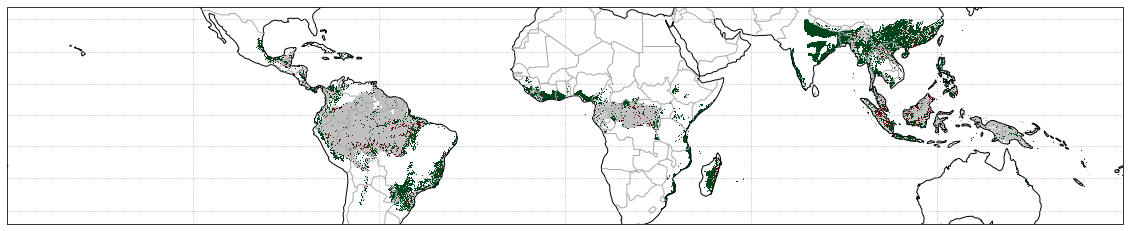

In [6]:
#set rows and columns
a = 1
b = 1

LON_Min=-120;
LON_Max=179.99;
LAT_Min=-30;
LAT_Max=30;

fig = plt.figure(figsize=(20,12)) #set sie of figure

extent = [LON_Min, LON_Max, LAT_Min, LAT_Max]
mpl.rcParams['hatch.color'] = 'grey'

ax = plt.subplot(a,b,1,projection = ccrs.Miller(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS, color = 'darkgrey')
for ri,region in enumerate(regions):
    
    LON = vars()[str(region)+'_biome']['lon']
    LAT = vars()[str(region)+'_biome']['lat']
    
    #first plot biome in Green
    plotvalue = vars()[str(region)+'_biome'].where(vars()[str(region)+'_biome'] > 0)
    im = plt.pcolormesh(LON,LAT,plotvalue,vmin=0,vmax=1,cmap=plt.cm.get_cmap('Greens'),transform=ccrs.PlateCarree())
    
    #plot the 75% tree cover locations in biome locations in Grey
    plotvalue1 = (vars()['treecover_' + str(region)]
                  .where(vars()['treecover_' + str(region)] >= CoverThreshold)
                 ).where(vars()[str(region)+'_biome'] > 0)
    im1 = plt.pcolormesh(LON,LAT,plotvalue1,vmin=0,vmax=CoverThreshold+200,cmap=plt.cm.get_cmap('Greys'),transform=ccrs.PlateCarree())

    #plot the loss locations in biome where 75% forest cover in Red
    plotvalue2 = ((vars()['lossyear_' + str(region)]
                   .where(vars()['lossyear_' + str(region)] >= LossYearCutoff)
                  ).where(vars()[str(region)+'_biome'] > 0)
                 ).where(vars()['treecover_' + str(region)] >= CoverThreshold)
    im2 = plt.pcolormesh(LON,LAT,plotvalue2,vmin=0,vmax=LossYearCutoff,cmap=plt.cm.get_cmap('Reds'),transform=ccrs.PlateCarree())
    
ax.set_extent(extent)

#plt.savefig('Figure1a_Maps_biome_hansenforest.tiff', format='tiff')